In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import multiprocessing as mp
from multiprocessing import Pool

from PFR_Processor_fantasy_teams import wrapper, process_func
from PFR_Model_Builder_fantasy_teams import create_and_evaluate_model, create_model

from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

from scikeras.wrappers import KerasRegressor

2023-05-03 08:30:54.586126: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
merged_data = pd.read_csv('merged_data.csv')

In [3]:
# Standardize numerical data
scaler = StandardScaler()
num_data = merged_data.select_dtypes(include=[np.number])
scaled = scaler.fit_transform(num_data)
scaled_df = pd.DataFrame(scaled, columns=num_data.columns)

# Copy original to keep str data
merged_data_scaled = merged_data.copy()

# Replace num columns with standardized data, except for 'Year'
for column in scaled_df.columns:
    if column != 'Year':
        merged_data_scaled[column] = scaled_df[column]

In [8]:
# Get pos from the 'FantPos' column
positions = merged_data_scaled['FantPos'].unique()

# Create empty dict to store models for each pos
models = {}

# Define hyperparameters to tune
param_grid = {
    'batch_size': [32, 64, 128],
    'epochs': [100, 200, 300],
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.1, 0.4, 0.6]
}

# Define num features to select w RFE
n_features = 16

# Define num folds for cv
n_folds = 5

In [9]:
import os
os.environ["JOBLIB_START_METHOD"] = "forkserver"  # Set the backend for joblib to 'forkserver'

In [11]:
from joblib import Parallel, delayed

# Prepare the arguments for the pool.map function
args_list = [(pos, merged_data_scaled, param_grid, n_folds, n_features) for pos in positions]

# Create a multiprocessing pool
n_jobs = 6
with Parallel(n_jobs=n_jobs, backend='multiprocessing') as parallel:
    # Use starmap to run the function with the given arguments in parallel
    results = parallel(delayed(create_and_evaluate_model)(*args) for args in args_list)

# Create a dictionary of models
models = {}
for result in results:
    pos, model,  X_test, y_test = result
    models[pos] = {
        'model': model,
        'X_test': X_test,
        'y_test': y_test
    }

2023-05-03 09:57:47.453952: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Creating model for position: RB
Selected features for RB: [ 4  5  6  7  8 10 14 15 19 20 21 24 26 30 31 32]


2023-05-03 09:57:52.809766: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 09:57:52.924861: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Creating model for position: WR
Selected features for WR: [ 4  5  8 14 23 24 25 26 33 34 35 36 37 38 39 40]


2023-05-03 09:57:58.375113: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 09:57:58.508718: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Creating model for position: QB


2023-05-03 09:58:09.499059: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Selected features for QB: [13 14 15 23 24 25 26 30 32 33 34 35 37 38 39 40]


2023-05-03 09:58:09.896656: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Creating model for position: TE
Selected features for TE: [ 5  8 10 15 20 23 24 25 26 30 31 32 33 34 35 36]


2023-05-03 09:58:34.041366: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Best Parameters: {'batch_size': 128, 'dropout_rate': 0.1, 'epochs': 100, 'optimizer': 'adam'}
Best MSE: 0.3723887264728546
Mean Squared Error for test data: 0.36412709951400757
Mean Absolute Error: 0.45213866233825684


2023-05-03 10:51:24.416511: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://23b49892af15418c89f56353f2abfe61: INVALID_ARGUMENT: ram://23b49892af15418c89f56353f2abfe61 is a directory.


Best Parameters: {'batch_size': 128, 'dropout_rate': 0.1, 'epochs': 100, 'optimizer': 'adam'}
Best MSE: 0.9630778431892395
Mean Squared Error for test data: 1.2257137298583984
Mean Absolute Error: 0.9130881428718567


2023-05-03 10:52:39.282181: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://10ef6329cffb4273b61beeb5f70061ce: INVALID_ARGUMENT: ram://10ef6329cffb4273b61beeb5f70061ce is a directory.


Best Parameters: {'batch_size': 128, 'dropout_rate': 0.4, 'epochs': 100, 'optimizer': 'rmsprop'}
Best MSE: 0.7021573901176452
Mean Squared Error for test data: 0.7727783918380737
Mean Absolute Error: 0.6899471282958984


2023-05-03 10:56:52.353017: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5e5477b07db34306ad0ea335e4915aeb: INVALID_ARGUMENT: ram://5e5477b07db34306ad0ea335e4915aeb is a directory.


Best Parameters: {'batch_size': 32, 'dropout_rate': 0.6, 'epochs': 200, 'optimizer': 'adam'}
Best MSE: 0.6077903985977173
Mean Squared Error for test data: 0.6098544001579285
Mean Absolute Error: 0.6194568872451782


2023-05-03 11:09:15.641115: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d7746228ba244078bc0c51b3452338eb: INVALID_ARGUMENT: ram://d7746228ba244078bc0c51b3452338eb is a directory.


ValueError: not enough values to unpack (expected 6, got 4)

In [ ]:
# iterate over the models dictionary
for pos, model_data in models.items():
    final_model, X_train, y_train, y_test, X_test = model_data
    
    # Make predictions on the test data
    y_pred = final_model.predict(X_test)

    # Calculate R-squared
    r2 = r2_score(y_test, y_pred)

    # Print the r2 score for each model
    print(f"R-squared for {pos}: {r2}")

{'RB': <keras.engine.sequential.Sequential at 0x131e04970>,
 'WR': <keras.engine.sequential.Sequential at 0x131c62aa0>,
 'QB': <keras.engine.sequential.Sequential at 0x13249d600>,
 'TE': <keras.engine.sequential.Sequential at 0x1314f27d0>}

In [6]:
# Loop through positions and create model for each
for pos in positions:
    print('Creating model for position:', pos)
    
    # Filter for training (< 2020) and for current pos
    train_data = merged_data_scaled[(merged_data_scaled['Year'] < 2020) & (merged_data_scaled['FantPos'] == pos)]

    # Filter for testing (< 2022 and not in training) and for current pos
    test_data = merged_data_scaled[(merged_data_scaled['Year'] < 2022) & (~merged_data_scaled.index.isin(train_data.index)) & (merged_data_scaled['FantPos'] == pos)]

    # Select input and outputs
    X_train = train_data.drop(['next_year_PPR', 'Year'], axis=1)
    X_train = X_train.select_dtypes(include=[np.number])  
    y_train = train_data['next_year_PPR']

    X_test = test_data.drop(['next_year_PPR', 'Year'], axis=1)
    X_test = X_test.select_dtypes(include=[np.number]) 
    y_test = test_data['next_year_PPR']

    # linear regression object
    lin_reg = LinearRegression()

    # Create RFE and specify the num of features to select
    rfe = RFE(lin_reg, n_features_to_select=n_features)

    # Fit RFE to training data
    rfe.fit(X_train, y_train)

    # Get selected features
    feature_index = rfe.get_support(indices=True)
    print(f'Selected features for {pos}: {feature_index}')

    # Filter training and testing data
    X_train = X_train.iloc[:, feature_index]
    X_test = X_test.iloc[:, feature_index]

    # Convert w np.array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # Create a KerasRegressor with the current model architecture
    model = KerasRegressor(model=create_model, dropout_rate=0.1, verbose=0)

    # Create a GridSearchCV object with the hyperparameters to tune and the cross-validation folds
    grid = GridSearchCV(estimator=model, param_grid={
        'input_shape': [X_train.shape[1:]],
        'neurons': [32, 64, 128],
        'dropout_rate': [0.1, 0.2],
        'optimizer': ['adam', 'rmsprop']
    }, cv=n_folds, n_jobs=-1, scoring='neg_mean_squared_error')

    # Fit the GridSearchCV object to the training data
    grid_result = grid.fit(X_train, y_train)

    # Get the best hyperparameters and the corresponding mean squared error score
    best_params = grid_result.best_params_
    best_score = -grid_result.best_score_

    print("Best Parameters:", best_params)
    print("Best MSE:", best_score)

    # Create the final model with the best hyperparameters and fit it to the training data
    final_model = create_model(dropout_rate=best_params['dropout_rate'], optimizer=best_params['optimizer'])
    final_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

    # Evaluate the final model on the test data
    mse, mae = final_model.evaluate(X_test, y_test, verbose=0)
    print("Mean Squared Error for test data:", mse)
    print("Mean Absolute Error:", mae)

    # Add the final model to the dictionary of models
    models[pos] = final_model

Creating model for position: RB
Selected features for RB: [ 4  5  6  7  8 10 14 15 19 20 24 26 30 31 32]


2023-05-03 08:23:18.575468: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 08:23:18.575464: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 08:23:18.575464: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

ValueError: Invalid parameter input_shape for estimator KerasRegressor.
This issue can likely be resolved by setting this parameter in the KerasRegressor constructor:
`KerasRegressor(input_shape=(15,))`
Check the list of available parameters with `estimator.get_params().keys()`

NameError: name 'X_test' is not defined

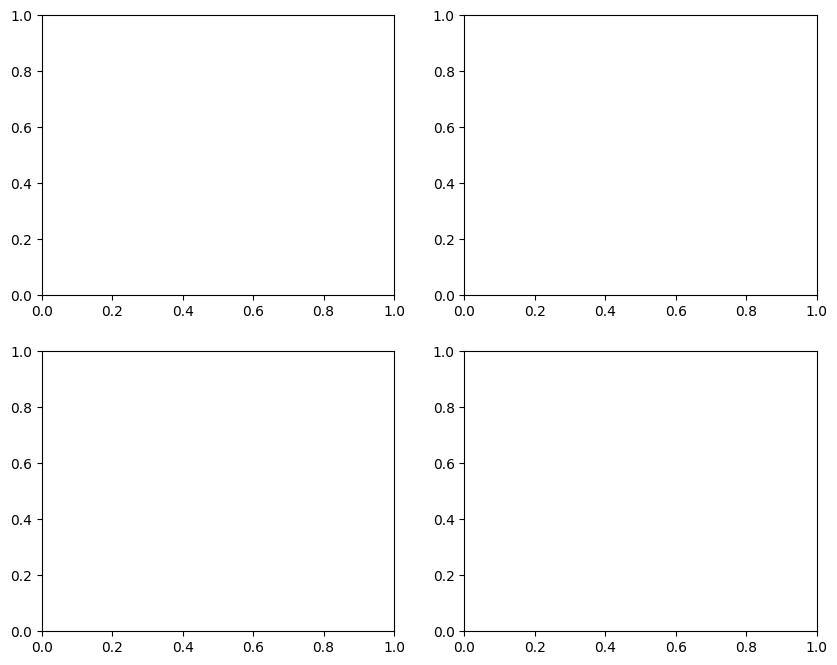

In [11]:
import matplotlib.pyplot as plt

# Define the figure and axes
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

# Loop through each position and make predictions on the test data
for i, (position, model) in enumerate(models.items()):

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Plot the predicted values against the actual values
    axs[i].scatter(y_test, y_pred)
    axs[i].set_xlabel("Actual")
    axs[i].set_ylabel("Predicted")
    axs[i].set_title("Predicted vs Actual for " + position)

# Adjust the spacing and layout of the subplots
plt.tight_layout()

# Show the figure
plt.show()